In [1]:
import os
import time
import random
import datetime
import numpy as np
import pandas as pd
import tensorflow as tf
from collections import Counter
import matplotlib.pyplot as plt
from IPython.display import FileLink
from tensorflow.keras.utils import *
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import *
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import *
from tensorflow.keras.initializers import *
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [ ]:
# Verifying if a GPU accelerator is correctly working
!nvidia-smi

### ***Prepping for the Training of our model***

In [3]:
# Verifying that Personal test data (ships-test) and Provided (ships2021) are accessible
!ls /kaggle/input

ships-test  shipsmano2021


In [4]:
# Verify if input contains the provided dataset tarball
!ls /kaggle/input/shipsmano2021

ships.tgz


In [5]:
# Extract provided dataset and others files from the tarball ships2021.tgz
!tar xzf /kaggle/input/shipsmano2021/ships.tgz

In [7]:
# Verifying that all 13 classes with their training data are correctly extracted
!ls /kaggle/working/ships_scaled/train

coastguard     corvette  cv	    ferry      sailing	  submarine  vsmallfish
containership  cruiser	 destroyer  methanier  smallfish  tug


In [8]:
# Extract personal test dataset tarball ships_test.tgz
!tar xzf /kaggle/input/ships-test/ships_test.tgz

In [45]:
# Verifying that all 13 classes with their test data are correctly extracted
!ls /kaggle/working/test

coastguard     corvette  cv	    ferry      sailing	  submarine  vsmallfish
containership  cruiser	 destroyer  methanier  smallfish  tug


### ***USEFUL VARIABLES***

In [53]:
LR = 0.0001
SEED = 42
EPOCHS = 10
CLASSES = 13
BATCH_SIZE = 64
x, y = 192, 128
VALIDATION_SPLIT = 0.1
TRAIN_DIR = "/kaggle/working/ships_scaled/train/"

### ***Training and Validation data generator***

In [54]:
# We will be using an ImageDataGenerator to create our Training and Validation data

imgdatagen = ImageDataGenerator(
        rescale=1./255,
        horizontal_flip=True,
        validation_split=VALIDATION_SPLIT,
        
        shear_range=0.1,
        zoom_range=0.1,
)

train_generator = imgdatagen.flow_from_directory(
        TRAIN_DIR,
        target_size=(x, y),
        batch_size=BATCH_SIZE,
        class_mode='categorical',
        color_mode="rgb",
        seed=SEED,
        subset="training"
)

validation_generator = imgdatagen.flow_from_directory(
        TRAIN_DIR,
        target_size=(x, y),
        batch_size=BATCH_SIZE,
        class_mode='categorical',
        color_mode="rgb",
        seed=SEED,
        subset="validation"
)

Found 42811 images belonging to 13 classes.
Found 4751 images belonging to 13 classes.


### ***Calulating class_weight to take in account the proportion of data per class***

In [55]:
counter = Counter(train_generator.classes)                          
max_val = float(max(counter.values()))       
class_weight = {class_id : max_val/num_images for class_id, num_images in counter.items()}    
class_weight

{0: 2.008990318118949,
 1: 1.0,
 2: 2.320287539936102,
 3: 1.0102590853764564,
 4: 3.3525678015002884,
 5: 1.0559796437659033,
 6: 1.8875893437296947,
 7: 1.958206943040108,
 8: 3.679544015199493,
 9: 2.080200501253133,
 10: 2.3909465020576133,
 11: 1.9897260273972603,
 12: 2.0371669004207575}

### ***Some useful callbacks to fine tune the model***

In [42]:
earlystop = EarlyStopping(monitor='val_accuracy',
                          min_delta=.0001,
                          patience=10,
                          verbose=1,
                          mode='auto',
                          baseline=None,
                          restore_best_weights=True)

reducelr = ReduceLROnPlateau(monitor='val_accuracy',
                             factor=1/3,
                             patience=4,
                             mode='auto',
                             min_delta=.0001,
                             cooldown=0,
                             min_lr=0.0000001)

modelckp = ModelCheckpoint('classifier.h5', 
                             monitor='val_accuracy', 
                             verbose=2, 
                             save_best_only=True, 
                             mode='max')

callbacks = [earlystop, reducelr, modelckp]

In [57]:
norm_axis = -1
inputShape = (x,y,3)
if K.image_data_format() == "channels_first":
    inputShape = (3, x, y)
    norm_axis = 1
print("Input Shape: ", inputShape)

model = Sequential([
    Conv2D(32, (3,3), activation="relu" , padding="same", input_shape=inputShape),
    BatchNormalization(axis=norm_axis),
    MaxPooling2D(pool_size=(3,3)),
    Dropout(0.25),

    Conv2D(64, (3,3), activation="relu", padding="same"),
    BatchNormalization(axis=norm_axis),
    Conv2D(64, (3,3), activation="relu", padding="same"),
    BatchNormalization(axis=norm_axis),
    MaxPooling2D(pool_size=(2,2)),
    Dropout(0.25),

    Conv2D(128, (3,3), activation="relu",  padding="same"),
    BatchNormalization(axis=norm_axis),
    Conv2D(128, (3,3), activation="relu",  padding="same"),
    BatchNormalization(axis=norm_axis),
    MaxPooling2D(pool_size=(2,2)),
    Dropout(0.25),

    Flatten(),
    Dense(1024, activation="relu"),
    BatchNormalization(),
    Dropout(0.5),

    Dense(CLASSES, activation="softmax"),
])

model.compile(optimizer=Adam(learning_rate=LR),
              loss='categorical_crossentropy',
              metrics=["accuracy"])


#print(model.summary())
print("Nombre de couches : ", len(model.layers))

Input Shape:  (192, 128, 3)
Nombre de couches :  21


In [59]:
#optimizer = RMSprop(lr=LR)
optimizer = Adam(lr=LR)

model.compile(optimizer=optimizer,
              loss="categorical_crossentropy",
              metrics=["accuracy"])

history = model.fit_generator(train_generator,
                              validation_data=validation_generator,
                              # steps_per_epoch=train_generator.n // train_generator.batch_size,
                              # validation_steps=validation_generator.n // validation_generator.batch_size,
                              epochs=5,
                              # callbacks=callbacks,
                              class_weight=class_weight,
                              verbose=1)

Epoch 1/5
669/669 [==============================] - 340s 506ms/step - loss: 3.1155 - accuracy: 0.4924 - val_loss: 4.6774 - val_accuracy: 0.2707
Epoch 2/5
669/669 [==============================] - 339s 507ms/step - loss: 2.0431 - accuracy: 0.6396 - val_loss: 1.5898 - val_accuracy: 0.5917
Epoch 3/5
669/669 [==============================] - 343s 513ms/step - loss: 1.6912 - accuracy: 0.6970 - val_loss: 0.9598 - val_accuracy: 0.7017
Epoch 4/5
669/669 [==============================] - 339s 506ms/step - loss: 1.4389 - accuracy: 0.7390 - val_loss: 0.9137 - val_accuracy: 0.7121
Epoch 5/5
669/669 [==============================] - 339s 507ms/step - loss: 1.2512 - accuracy: 0.7721 - val_loss: 0.9548 - val_accuracy: 0.7188


**To get better results the model would've needed a bit more epochs to train. Here it only ran for 5 epochs**

### ***Plots of Accuracy and Loss history to see if the accuracy increases and loss decreases as required***

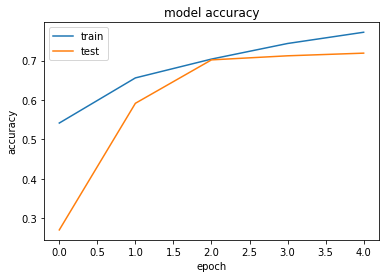

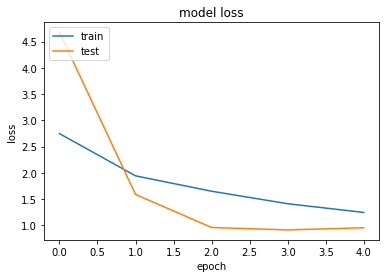

In [60]:
# Accuracy History Plot
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# Loss History Plot
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

***As seen before the model's accuracy was increasing and the loss was decreasing quite well. To get better results it would've been great to run it for a few more epochs.***

### ***Evaluating model on validation data***

In [61]:
score = model.evaluate_generator(validation_generator, validation_generator.n/validation_generator.batch_size)
print("Loss: ", score[0], "Accuracy: ", score[1])

/opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1877: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  warnings.warn('`Model.evaluate_generator` is deprecated and '


Loss:  0.9574021697044373 Accuracy:  0.7179540991783142


### ***Making predictions on test data***

In [62]:
# Loading provided test images to test our model with them
X_test = np.load('/kaggle/working/test.npy', allow_pickle=True)
X_test = X_test.astype('float32')

# Predict and save output to reco_nav.csv for submission on kaggle
res = model.predict(X_test).argmax(axis=1)
df = pd.DataFrame({"Category":res})
df.to_csv("reco_nav.csv", index_label="Id")

In [63]:
# Creating a link to download the predictions output on test images
os.chdir(r'/kaggle/working/')
FileLink(r'reco_nav.csv')

/kaggle/working/reco_nav.csv

In [65]:
!head -15 reco_nav.csv

Id,Category
0,6
1,8
2,8
3,11
4,12
5,11
6,6
7,6
8,8
9,11
10,11
11,6
12,11
13,12


In [66]:
validation_generator.class_indices

{'coastguard': 0,
 'containership': 1,
 'corvette': 2,
 'cruiser': 3,
 'cv': 4,
 'destroyer': 5,
 'ferry': 6,
 'methanier': 7,
 'sailing': 8,
 'smallfish': 9,
 'submarine': 10,
 'tug': 11,
 'vsmallfish': 12}

### ***Classification Report & Confusion Matrix***

In [67]:
# Reset Validation_generator to build a correct classification report
validation_generator.reset()

# Make predictions on validation data
predictions = model.predict_generator(validation_generator, steps=len(validation_generator))
# Extracting the max value from the predictions made on the validation data
val = np.argmax(predictions, axis=1)

# Make a Classification Report
report = classification_report(y_true=validation_generator.classes, y_pred=val, target_names=validation_generator.class_indices)
print(report)

/opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


               precision    recall  f1-score   support

   coastguard       0.05      0.04      0.04       321
containership       0.13      0.13      0.13       645
     corvette       0.08      0.07      0.07       278
      cruiser       0.15      0.13      0.14       639
           cv       0.05      0.07      0.06       192
    destroyer       0.12      0.19      0.14       611
        ferry       0.11      0.05      0.07       341
    methanier       0.08      0.08      0.08       329
      sailing       0.06      0.06      0.06       175
    smallfish       0.05      0.05      0.05       310
    submarine       0.07      0.06      0.06       270
          tug       0.07      0.12      0.09       324
   vsmallfish       0.08      0.03      0.05       316

     accuracy                           0.10      4751
    macro avg       0.08      0.08      0.08      4751
 weighted avg       0.10      0.10      0.09      4751



<AxesSubplot:>

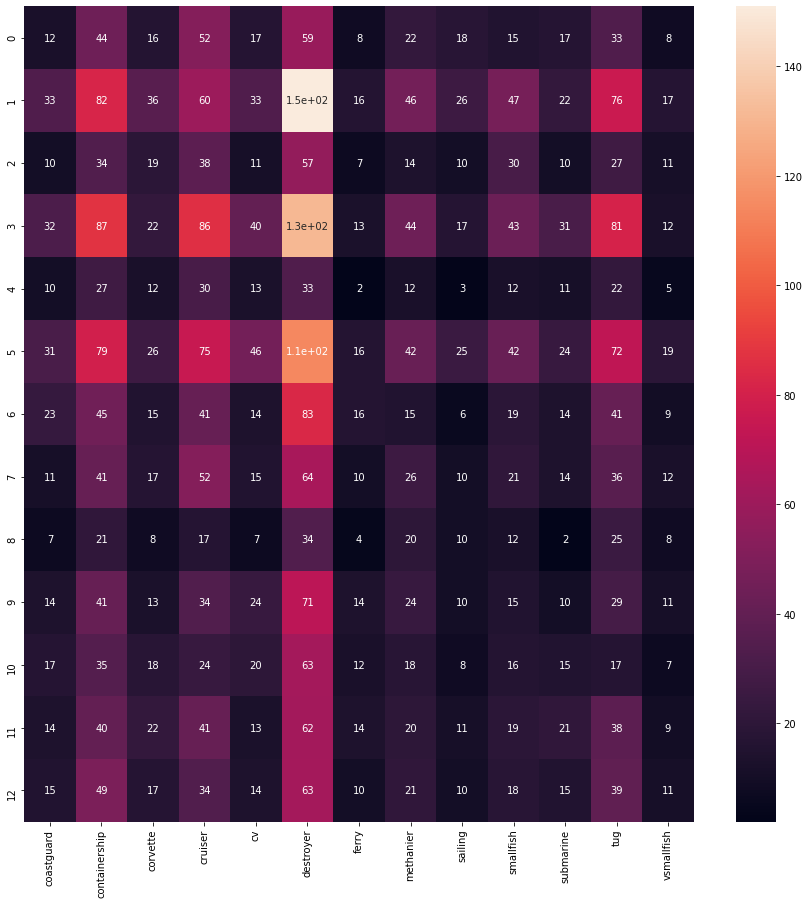

In [68]:
# Displaying a Confusion Matrix
con_matrix = confusion_matrix(validation_generator.classes, val)
df = pd.DataFrame(con_matrix, columns=validation_generator.class_indices)
plt.figure(figsize=(15,15))

# Using Seaborn to plot the Confusion Matrix
import seaborn as sn
sn.heatmap(df, annot=True)

 ***We can see the effect of undertrainning a model here the confusion matrix is all over the place as the predictions made by the model are not accurate enough.***

### ***Testing on 20+ images to do a test on realife data very diffrent from provided training data***

0


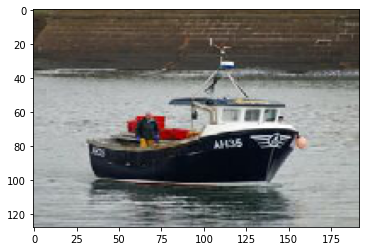

In [69]:
# First Method of testing 
from keras_preprocessing.image import img_to_array, array_to_img, load_img
import matplotlib.pyplot as plt
test = '/kaggle/working/test'
categories = os.listdir(test)
XT = []
yt = []
for dirname, _, filenames in os.walk(test):
    dirn = dirname.split(os.path.sep)[-1]
    if (dirn != 'test'):
        cat = categories.index(str(dirn))
        for filename in filenames[:4]:
            img = load_img(str(os.path.join(dirname, filename)),
                           target_size=(128, 192 ))
            img_array = img_to_array(img) / 255
            XT.append(img_array)
            yt.append(cat)

print(yt[2])
plt.imshow(XT[2])
XT = np.array(XT)

In [70]:
XT = XT.astype('float32')
res = model.predict(XT).argmax(axis=1)
sum(yt == res) / len(res) * 100

1.9230769230769231

In [71]:
# Second Method of testing using ImageDataGenerator
# Test directory where pers
TEST_DIR = "/kaggle/working/test"

testgen = ImageDataGenerator(rescale=1./255)

test_generator = testgen.flow_from_directory(
        TEST_DIR,
        target_size=(128, 192),
        batch_size=4,
        class_mode='categorical',
)

test_score = model.evaluate_generator(test_generator, len(test_generator))
print("Loss: ", test_score[0], "Accuracy: ", test_score[1])

Found 52 images belonging to 13 classes.


/opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1877: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  warnings.warn('`Model.evaluate_generator` is deprecated and '


Loss:  6.267397403717041 Accuracy:  0.3461538553237915


In [72]:
# Confirming that all classes have the same num of images
counter = Counter(test_generator.classes)                          
max_val = float(max(counter.values()))       
class_weight = {class_id : num_images for class_id, num_images in counter.items()}    
class_weight

{0: 4,
 1: 4,
 2: 4,
 3: 4,
 4: 4,
 5: 4,
 6: 4,
 7: 4,
 8: 4,
 9: 4,
 10: 4,
 11: 4,
 12: 4}

In [73]:
test_generator.reset()
testpredictions = model.predict_generator(test_generator, steps=len(test_generator))
testy = np.argmax(testpredictions, axis=1)

testreport = classification_report(y_true=test_generator.classes, y_pred=testy, target_names=test_generator.class_indices)
print(testreport)

               precision    recall  f1-score   support

   coastguard       0.00      0.00      0.00         4
containership       0.20      0.25      0.22         4
     corvette       0.00      0.00      0.00         4
      cruiser       0.00      0.00      0.00         4
           cv       0.13      0.75      0.22         4
    destroyer       0.00      0.00      0.00         4
        ferry       0.00      0.00      0.00         4
    methanier       0.00      0.00      0.00         4
      sailing       0.17      0.25      0.20         4
    smallfish       0.00      0.00      0.00         4
    submarine       0.00      0.00      0.00         4
          tug       0.00      0.00      0.00         4
   vsmallfish       0.00      0.00      0.00         4

     accuracy                           0.10        52
    macro avg       0.04      0.10      0.05        52
 weighted avg       0.04      0.10      0.05        52



/opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245

<AxesSubplot:>

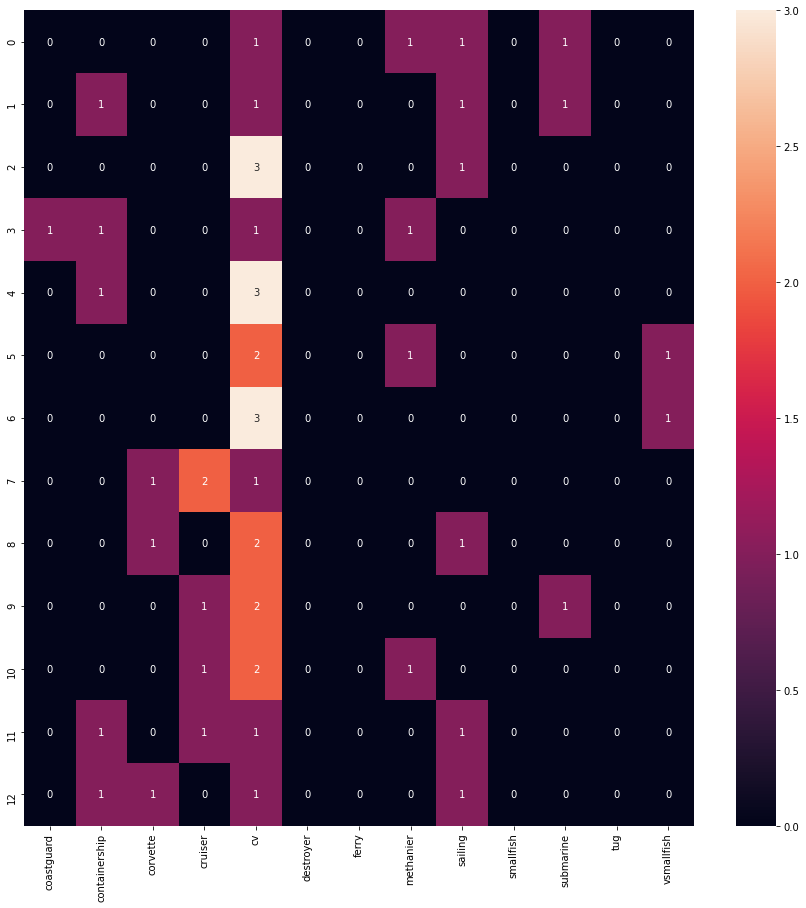

In [74]:
testmatrix = confusion_matrix(test_generator.classes, testy)
testdf = pd.DataFrame(testmatrix, columns=test_generator.class_indices)
plt.figure(figsize=(15,15))
import seaborn as sn
sn.heatmap(testdf, annot=True)

***Due to lack of gpu ressources at the time of training i could only train my model for only 5 epochs to submit my work on time. And due to the lack of time we can see the results of an undertrained model.***